# AutoShopper

# 1. Problem:

When shopping for a used vehicle, typically the overriding concern is: ** *Am I paying too much?* **  This question is often difficult to answer due to the fact that it's hard to keep track of all the vehicles of interest currently available on the market. 

A second, and related concern, is: ** *Which vehicles with similar specifications are available?* ** This information can help the buyer get a feel for what else is available on the market and provide and indication of the value of the vehicle currently under consideration.

# 2. Goal:

This project has two goals. The first is to build a model that determines if the asking price for a particular car is reasonable given the information provided in the listing. Additionally, the code will provide reccomendations for related vehicles with lower price, lower miles, and one that is slightly more expensive. 

# 3. Data:

The data were obtained by scraping http://www.cars.com with the following limitations:
- Only used cars with photos (collected ~225k photos)
- Model years between 2005-2016
- Vehicles located within 75 miles of San Francisco, CA or San Diego, CA
- Minimum price $5000

Because I was unable to get an API key, it was necessary to use the selenium package to retrieve ad id value that enabled me to collect the specifics for each ad. Notebook with code and specifics regarding data collection is available at [cars_com_scraping](https://github.com/clrife/DSI-SF-2-clrife/blob/master/capstone/code/carscom_scraping_92027.ipynb). I collected information from 50,000 ad listings. 


<h1><center>Carscom Data Dictionary</center></h1>

ColumnID | Description 
---------|-------------
ad_id    | Unique numeric identifier for the ad
bodyStyle | Describes type of vehicle (sedan, coupe, etc)
city | City name where the car is listed
dealerName | Name of the listing dea;er
doorCount | Number of doors the vehicle has
downloadDate | Date the listing was downloaded
drivetrain | Which wheels are driven
engine | Engine description
exteriorColor | Exterior color
fuelType | Type of fuel used
interiorColor | Interior color
isGhostPhoto | True if the photo is a placeholder image
isStockPhoto | True if the photo is not of the actual vehicle
listingDate | When the listing was originally posted
location | Location of the vehicle in lat,long coordinate system
makeName | Make of vehicle
miles | Number of miles on the vehicle
modelName | Model name of vehicle
modelYear | Model year of cehicle
mpgCity | Miles per gallon, city
mpgHwy | Miles per gallon, highway
oneOwner | True if the vehicle only had one previous owner
photoUrlsLarge | List containing URLs to the listing photos
price | Asking price of the vehicle
privatePartyListing | True if not being sold by a dealer
seatCapacity | How many seats
sellerNotesPt1 | Part 1 of the seller's description
sellerNotesPt2 | Part 2 of the seller's description
sellerPhotoCount | Number of photos with the listing
state | State where vehicle is for sale
transmission | Type of transmission
trimName | Trim level
vin | Vehicle identification number
zipcode | Zipcode where vehicle is listed


# 4. Data Cleaning

Import packages

In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle
import math
import os
from shutil import copyfile
from datetime import datetime

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# plot styles
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

Read in the data. There is one pickled file for each combination of year and zipcode

In [2]:
# get the list of pickled files from the directory
listdir = os.listdir('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_listings/')[1:-1]

# create a datafram to hold the results
cc_data = pd.DataFrame()

# iterate through the files and add each one to the df
for listing in listdir:
    path = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_listings/' + listing
    f = open(path,'r')
    temp = cPickle.load(f)
    f.close
    
    # concatenate the dataframes
    cc_data = pd.concat((cc_data,temp))

cc_data.shape

(49629, 34)

### Convert some column data types

- listingDate to datetime
- mpgCity to int
- mpgHwy to int
- modelYear to int

In [3]:
# listing date to datetime
cc_data.listingDate = pd.to_datetime(cc_data.listingDate)

# mpgCity to int
cc_data.mpgCity = cc_data.mpgCity.map(lambda x: int(x) if x != None else None)

# mpgHwy to int
cc_data.mpgHwy = cc_data.mpgHwy.map(lambda x: int(x) if x != None else None)

# modelYear to int
cc_data.modelYear = cc_data.modelYear.astype('int')

Due to the way that the listings were presented to selenium, certain *sponsored listings* appeared on nearly every page. This can be removed by limiting the dataset to only contain unique VIN's (vehicle identification number).

For the same reason that there were duplicate vins, there are some listings returned that are outside of my year range (2005-2016). Remove the entries outside that range

In [4]:
# clean up vin's
print 'rows before removing duplicates:', cc_data.shape[0]
cc_data.drop_duplicates('vin',inplace=True)
print 'rows after removing duplicates:', cc_data.shape[0]

# limit years
print '\nrows before filtering years:', cc_data.shape[0]
cc_data = cc_data[(cc_data.modelYear >= 2005) & (cc_data.modelYear <= 2016)]
print 'rows after  filtering years:', cc_data.shape[0]

rows before removing duplicates: 49629
rows after removing duplicates: 46018

rows before filtering years: 46018
rows after  filtering years: 46015


Oddly, a lot of the mercedes listings have nothing for modelName, however the model is contained in trimName. It's not shown here, but the mercedes photos were also missing model names and needed correction.

In [5]:
def calc_mb_modelName(df):
    # function to extract the mercedes model name from trimName
    # and update them both in the data frame
    
    # find model name
    if df.modelName == '':
        if df.trimName:
            model = df.trimName.split()[0]
            trim = " ".join(df.trimName.split()[1:])
            df.modelName = model
            df.trimName = trim
            
    # return the df
    return df


cc_data =  cc_data.apply(calc_mb_modelName,axis=1)

Drop any instances where there is no: make, model, year

In [6]:
print "%s rows before drops" % cc_data.shape[0]
cc_data.makeName.dropna(inplace=True)
cc_data.modelYear.dropna(inplace=True)

# model year requires a bit more work
# values of "" need to be explicitly converted to NaN before being dropped
cc_data.modelName.replace('', np.nan, inplace=True)
cc_data.dropna(subset=['modelName'], inplace=True)
print "\n%s rows after drops" % cc_data.shape[0]

46015 rows before drops

45838 rows after drops


Drop vehicles that have door count of 0

In [7]:
# drop vehicles without doorCount
cc_data = cc_data[cc_data.doorCount > 0]

Look at miles. No or super low miles is not believeable or useable... same with super high miles

In [8]:
# lowest miles
cc_data[['modelYear','makeName','modelName','miles']].sort_values(by='miles',ascending=True).head(5)

,modelYear,makeName,modelName,miles
799,2006,Chevrolet,Express 2500,-1.0
754,2006,Chevrolet,Silverado 1500,0.0
753,2006,Honda,Accord,0.0
750,2006,Honda,Accord,0.0
745,2006,Mercury,Mountaineer,0.0


In [9]:
# also look at high end of miles
cc_data[['modelYear','makeName','modelName','miles','sellerNotesPt1']].sort_values(by='miles',ascending=False).head(10)

,modelYear,makeName,modelName,miles,sellerNotesPt1
2187,2016,Jeep,Compass,731755.0,None
71,2005,Ford,F250,354883.0,At Auto Finance Experts we are leaders in supe...
510,2014,Chrysler,Town & Country,346041.0,"At MVP, we make it easy to find your next vehi..."
300,2005,Ford,F350,305821.0,*** NORTH COUNTY SAN DIEGO'S #1 USED CAR DEALE...
407,2005,Ford,F150,304149.0,None
390,2006,Ford,F250,278265.0,Highway miles.Ice cold A/C.Looks &amp; runs gr...
284,2011,Ford,F450,275079.0,Mike's Auto Sales is the only place to go when...
781,2010,Honda,CR-V,270063.0,EXCELLENT FINANCING OPTIONS... BAD CREDIT? NO ...
512,2006,Toyota,4Runner,265127.0,One Owner! Clean CARFAX! Non-smoker! This 2006...
367,2007,Toyota,Tacoma,262559.0,Check out this 2007 Toyota Tacoma PreRunner. T...


In [10]:
# will limits miles to at least 500 to rule out some "new" used cars
# there will probably still be cases where the miles are listed incorrectly
print 'Vehicles with fewer than 500 miles:', cc_data.vin[cc_data.miles < 500].count()
cc_data = cc_data[cc_data.miles > 500]

# most of the high miles coule be real... except for the super high mileages on basically new cars
# filter out vehicles over 300k miles
print '\nVehicles with more than 300k miles: %s' % cc_data.miles[cc_data.miles > 300000].count()
cc_data = cc_data[cc_data.miles < 300000]

Vehicles with fewer than 500 miles: 422

Vehicles with more than 300k miles: 5


Take a look at the highest/lowest prices and see if they make sense...

In [11]:
cc_data[['modelYear','makeName','modelName','price']].sort_values(by='price',ascending=False).head(20)

,modelYear,makeName,modelName,price
16,2010,Bugatti,Veyron,2300000.0
62,2015,Porsche,918 Spyder,1999999.0
63,2015,Porsche,918 Spyder,1999999.0
56,2015,Porsche,918 Spyder,1700000.0
3,2011,Ferrari,599 GTB Fiorano,1600000.0
8,2015,Porsche,918 Spyder,1400000.0
68,2005,Porsche,Carrera GT,799999.0
53,2011,Ferrari,599 GTO,799599.0
23,2015,Ferrari,458 Spider,749000.0
40,2005,Porsche,Carrera GT,729888.0


A cursory look suggests that the high-priced vehicles are likely not the result of typos. More likely to see incorrect values at the low end as advertisers try to get interest by putting super low prices (i.e., $1) so they show up first when sorted by ascending price.

Actually, that won't be an issue here, as I controlled for that already by setting a minimum price of $5000 when collecting the ads...

In [12]:
cc_data[['modelYear','makeName','modelName','price']].sort_values(by='price',ascending=True).head(20)

,modelYear,makeName,modelName,price
816,2006,Mazda,Mazda5,5150.0
803,2006,Pontiac,G6,5200.0
353,2005,Toyota,Corolla,5200.0
797,2006,Chrysler,300C,5299.0
372,2005,Chevrolet,Cobalt,5350.0
361,2005,Ford,Focus,5390.0
822,2006,Mercedes-Benz,S350,5400.0
723,2006,Scion,tC,5450.0
738,2006,Audi,A4,5475.0
721,2006,Mazda,Mazda3,5475.0


Look at the range for price and miles. Both have a very large spread. This is not suprising given the mix of vehicle listings compiled- from daily driven work trucks to high-end exotics. The price/miles relationships will be further explored in EDA.

In [13]:
cc_data[['price','miles']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,44745.0,25397.08830,31535.215150,5150.0,14991.0,20249.0,28950.0,2300000.0
miles,44745.0,46553.83435,34423.477566,502.0,22068.0,36895.0,63479.0,278265.0


### At this point the data has been tidied up enough to proceed to EDA

# 5. EDA

First question, how many makes, models and trim leves are in the dataset?

In [14]:
print 'Number of unique years is %s' % len(cc_data.modelYear.unique())
print 'Number of unique makes is %s' % len(cc_data.makeName.unique())
print 'Number of unique models is %s' % len(cc_data.modelName.unique())
print 'Number of unique trim levels is %s' % len(cc_data.trimName.unique())

Number of unique years is 12
Number of unique makes is 52
Number of unique models is 730
Number of unique trim levels is 1521


In [15]:
# reset index so functions don't complain later 
cc_data.reset_index(inplace=True,drop=True)

Distribution of data vs model year

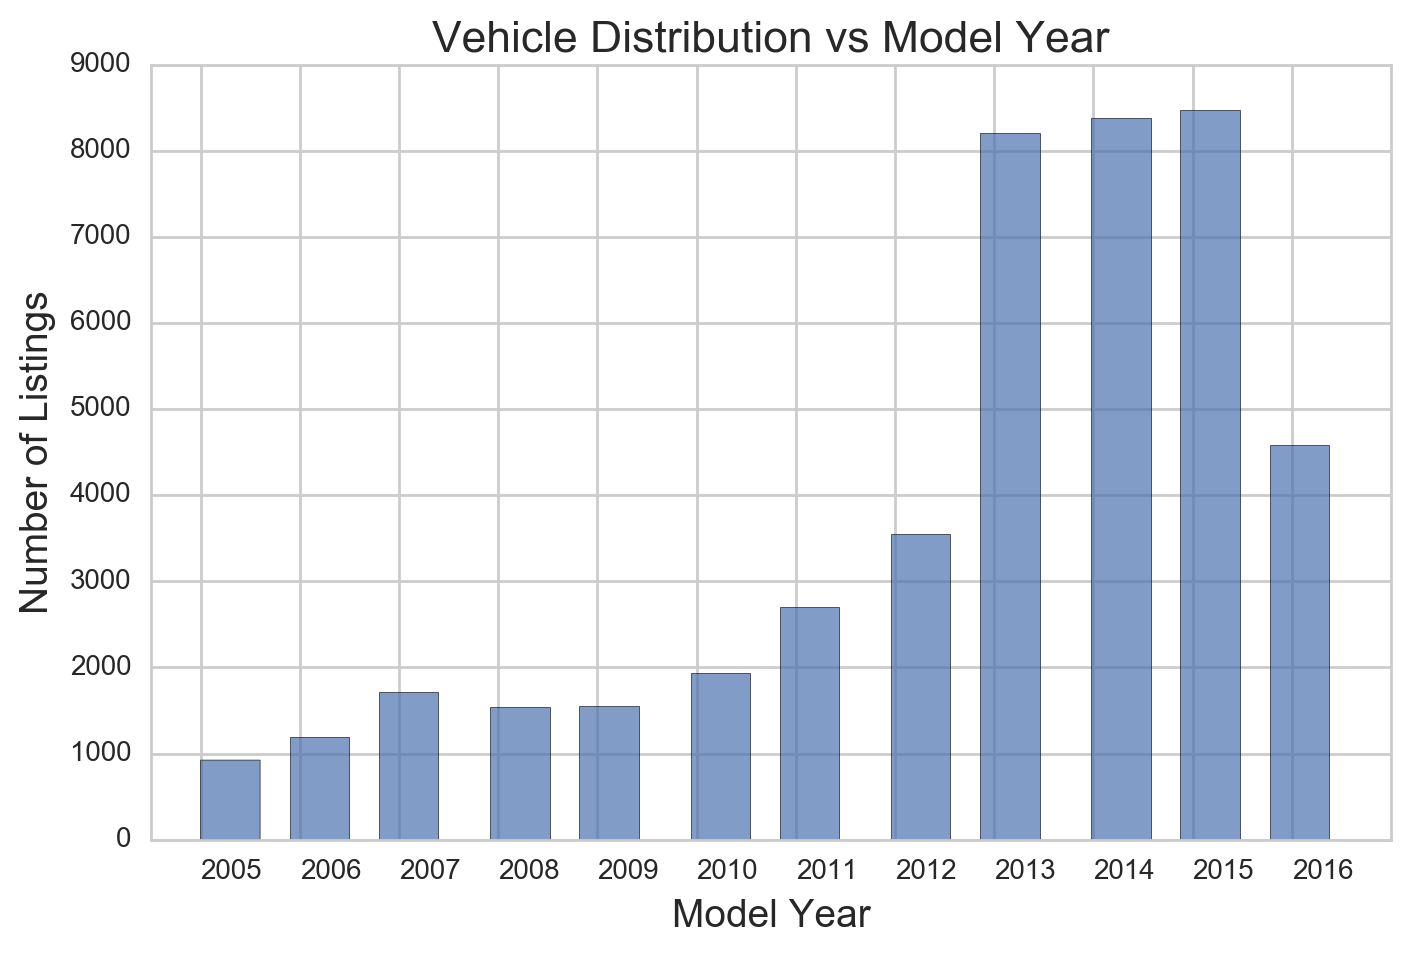

In [16]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(cc_data.modelYear,kde=False, hist_kws={"alpha":0.7,'width':0.6})
plt.title('Vehicle Distribution vs Model Year',fontsize=16)
plt.xticks(sorted(cc_data.modelYear.unique()),horizontalalignment='left')
plt.ylabel('Number of Listings',fontsize=14)
plt.xlabel('Model Year', fontsize=14)
plt.xlim(2004.5,2017)
plt.show()

Miles distribution over all the listings.

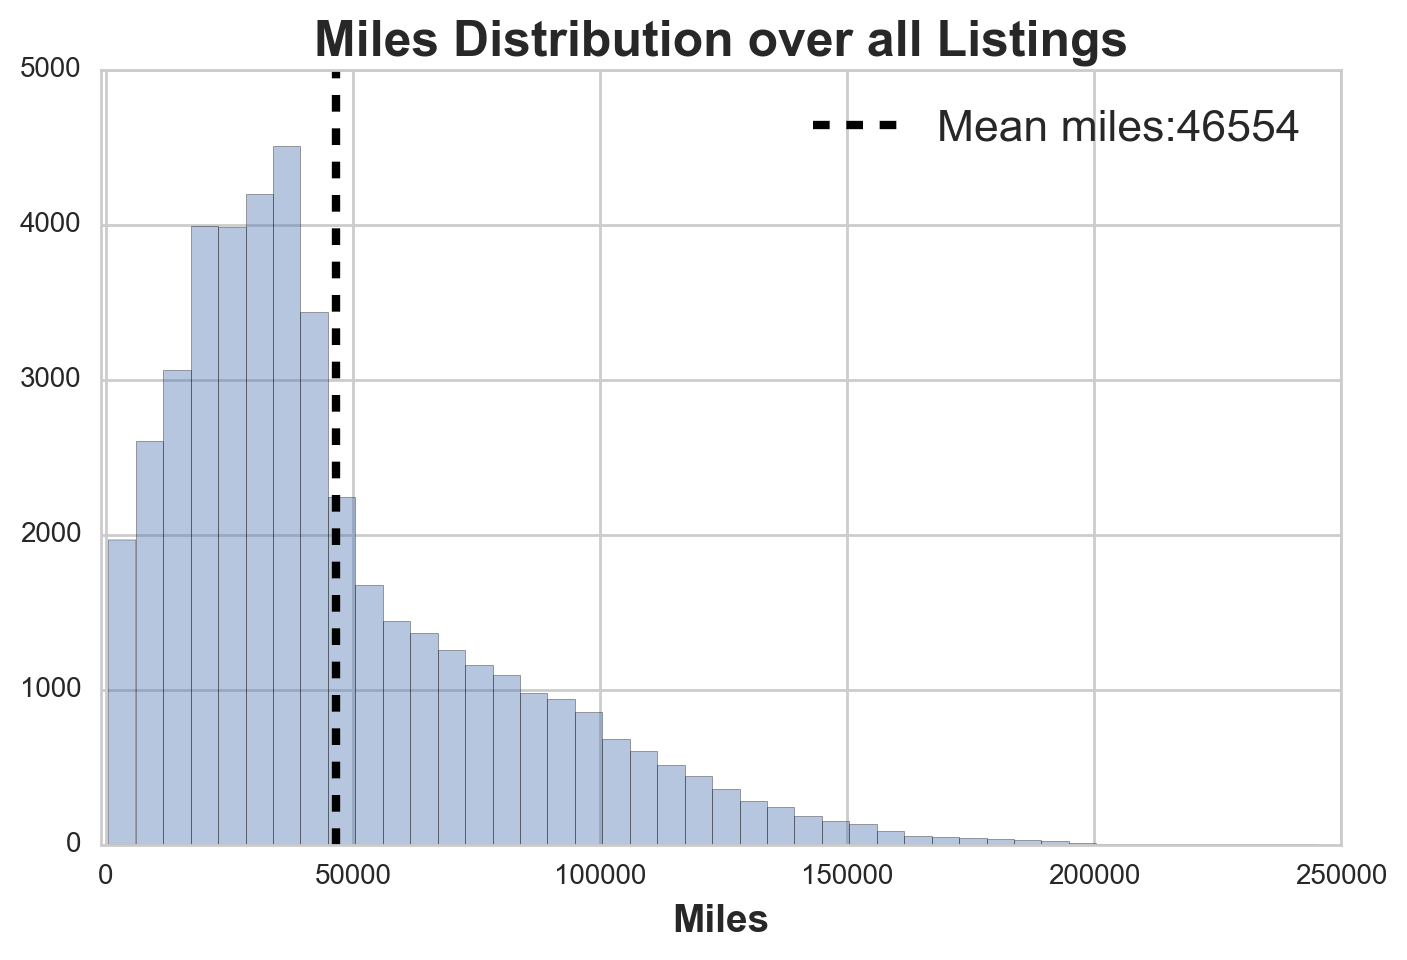

In [17]:
# look at miles overall distribution
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(cc_data.miles,kde=False)
plt.xlabel('Miles',fontsize=14,fontweight="bold")
plt.axvline(cc_data.miles.mean(),lw=3,ls='dashed',
            color='black',label='Mean miles:'+'{0:.0f}'.format(np.mean(cc_data.miles)))
plt.title('Miles Distribution over all Listings',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,250000)
plt.show()

Distribution of miles per year. Showing boxplot to get a better feel for the ranges and possible outliers.

Quite a few vehicles have very low miles.

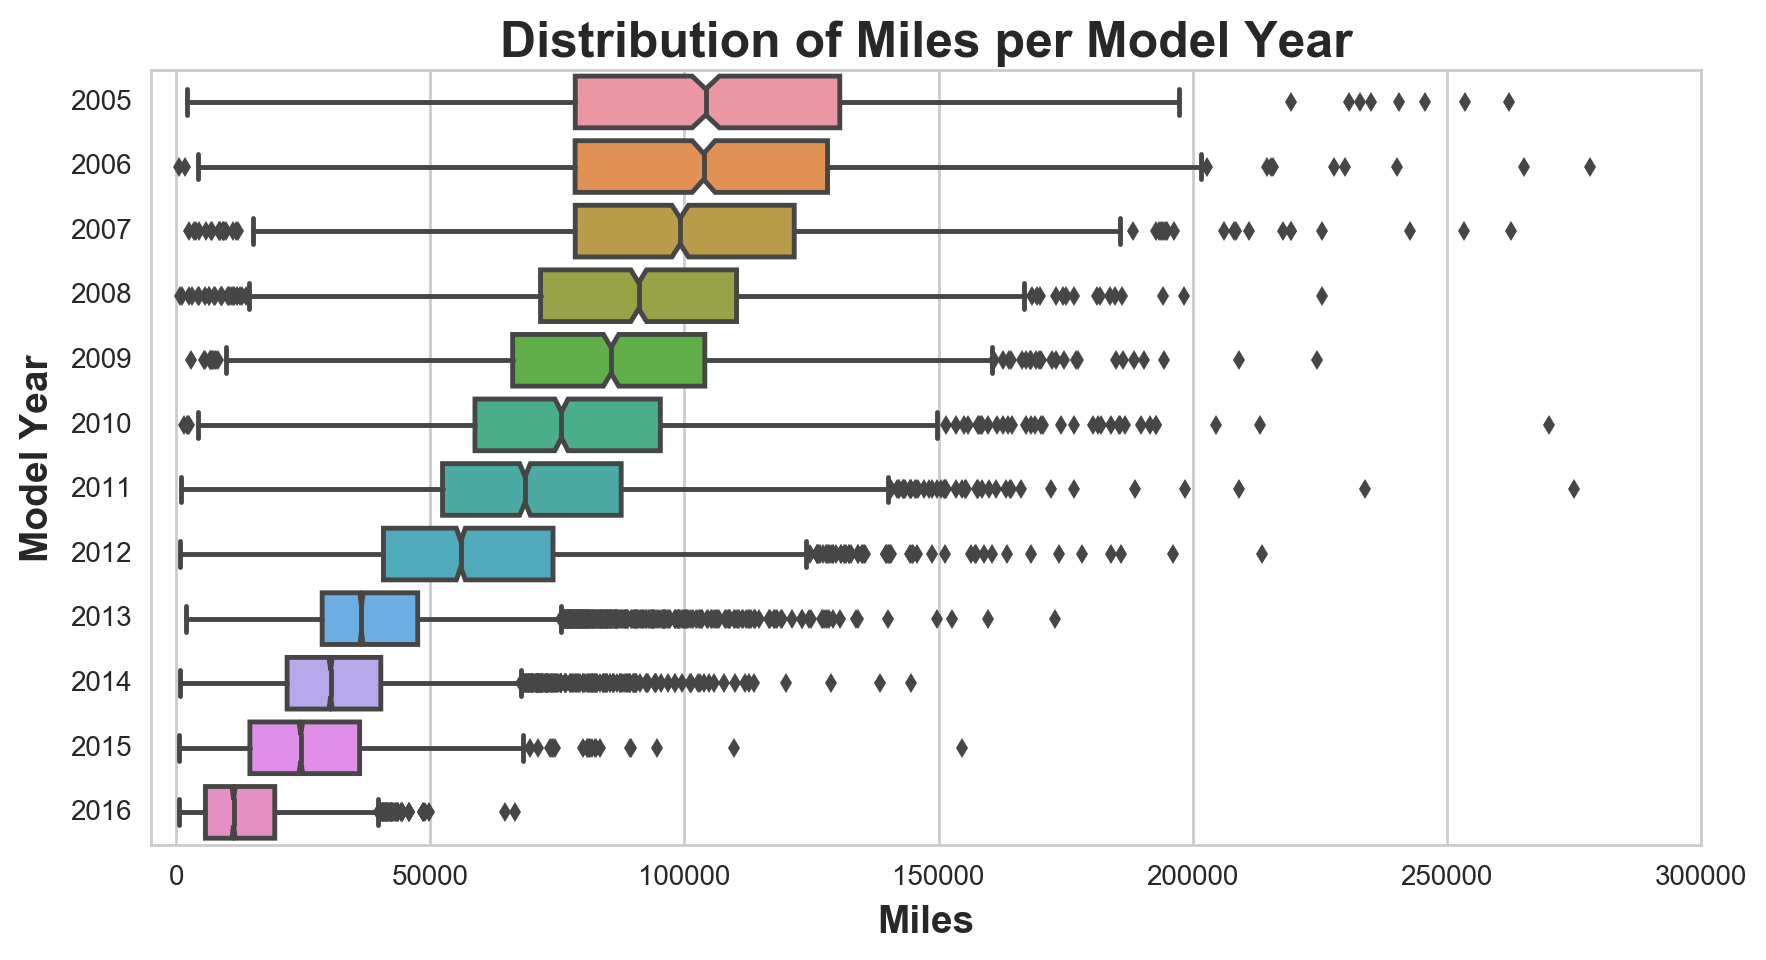

In [18]:
# look at miles by year boxplot
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.boxplot(x='miles',y='modelYear',data=cc_data,notch=True,orient='h')
plt.xlabel('Miles',fontsize=14,fontweight="bold")
ax.set_yticklabels(sorted(cc_data.modelYear.unique()))
plt.ylabel('Model Year',fontsize=14,fontweight="bold")
plt.title('Distribution of Miles per Model Year',fontsize=18,fontweight="bold")
plt.xlim(-5000,300000)
plt.show()

Overall price distribution. Limiting it to $150k on the high end, as it tails off quite a bit to reach the highest price of $2M.

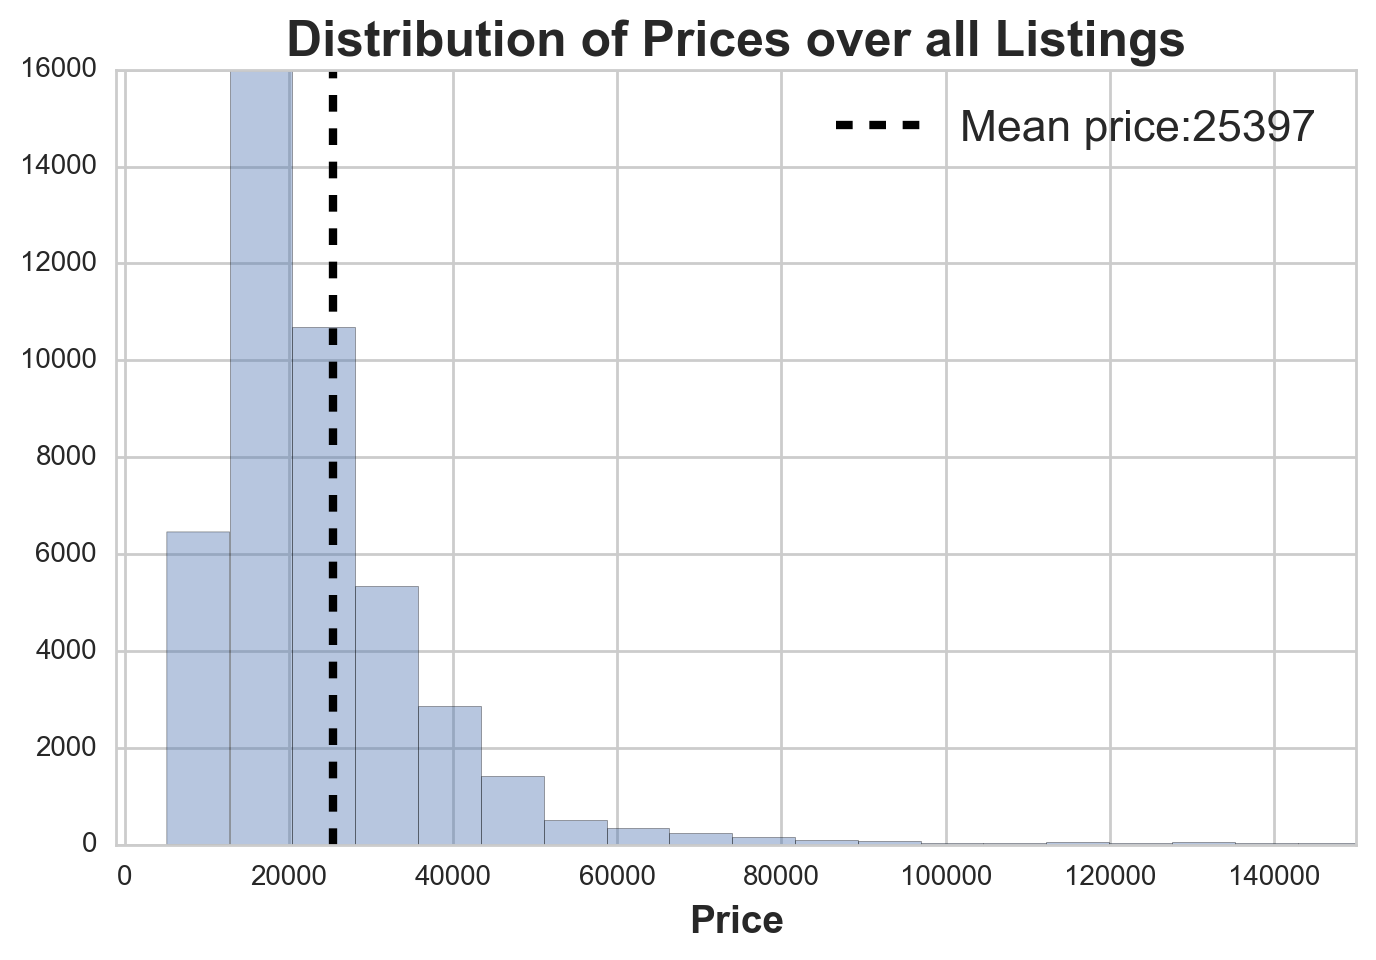

In [19]:
# look at price distribution
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(cc_data.price,kde=False,bins=300)
plt.xlabel('Price',fontsize=14,fontweight="bold")
plt.axvline(cc_data.price.mean(),lw=3,ls='dashed',
            color='black',label='Mean price:'+'{0:.0f}'.format(np.mean(cc_data.price)))
plt.title('Distribution of Prices over all Listings',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,150000)
plt.show()

Price per year boxplot with the same price restriction as above.

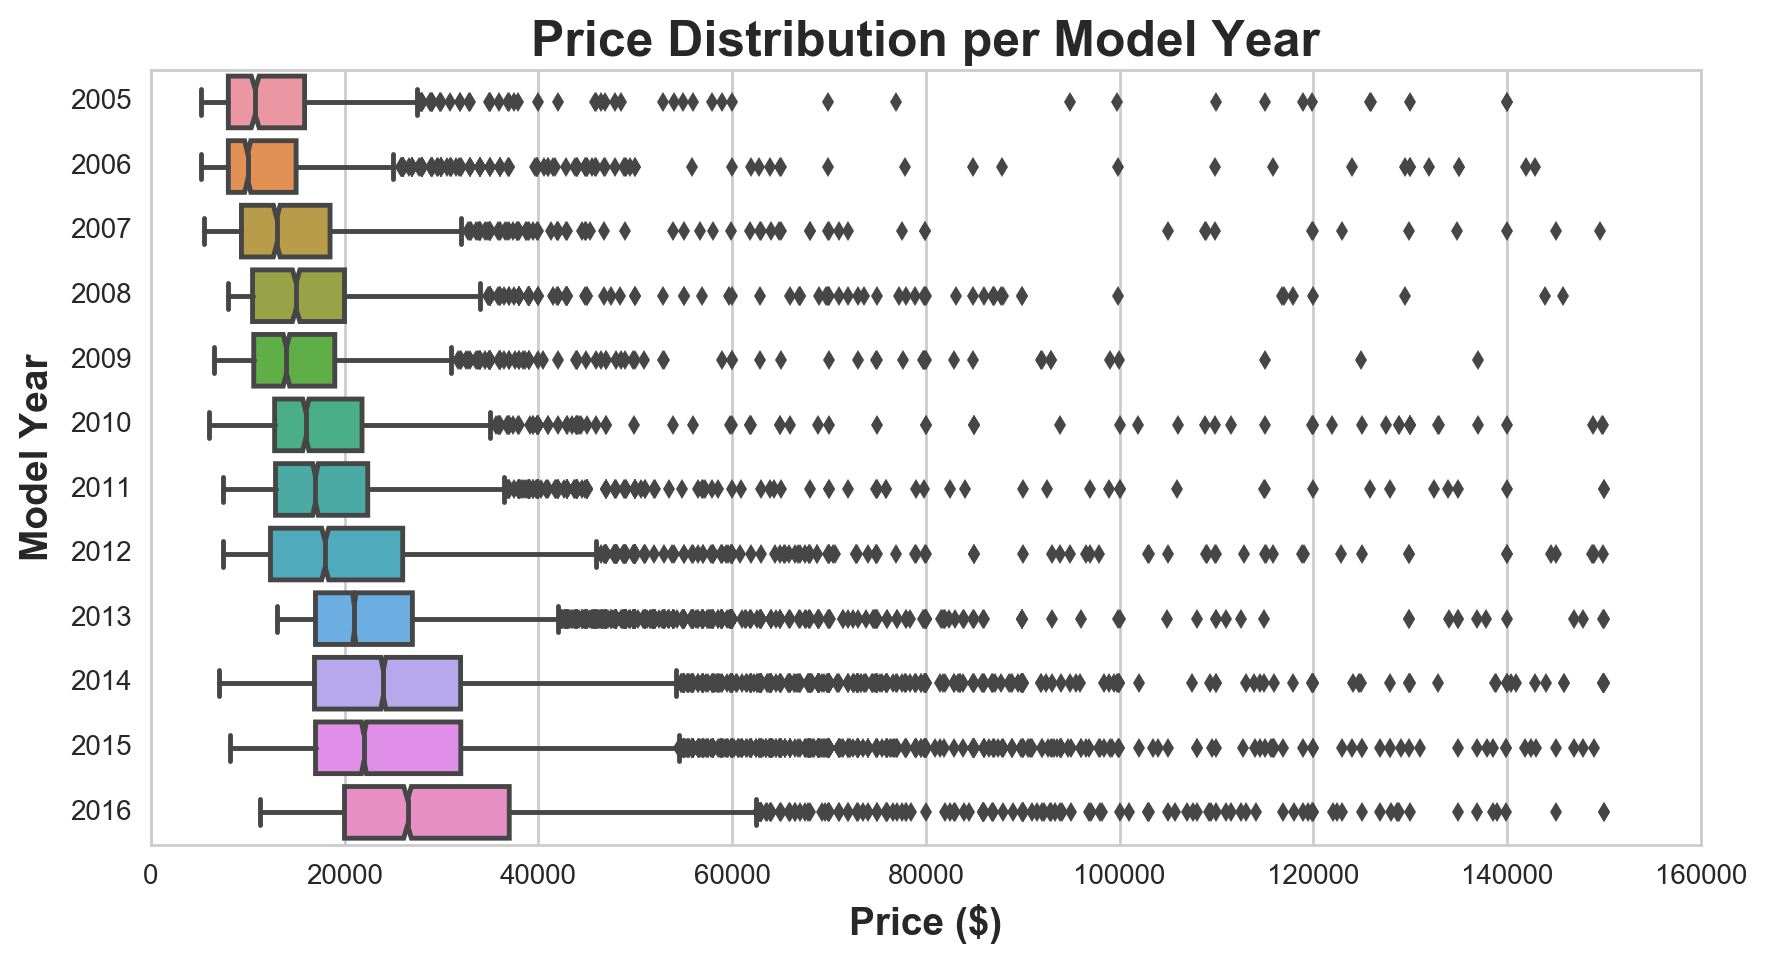

In [20]:
# look at price by year boxplot
# limit upper prices so it's more informative
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.boxplot(x='price',y='modelYear',data=cc_data[cc_data.price < 150000],
            order=sorted(cc_data.modelYear.unique()),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=14,fontweight="bold")
#ax.set_yticklabels(sorted(cc_data.modelYear.unique()))
plt.ylabel('Model Year',fontsize=14,fontweight="bold")
plt.title('Price Distribution per Model Year',fontsize=18,fontweight="bold")
plt.show()

Now for the fun stuff! Look at prices by make. These next couple of plots are large!

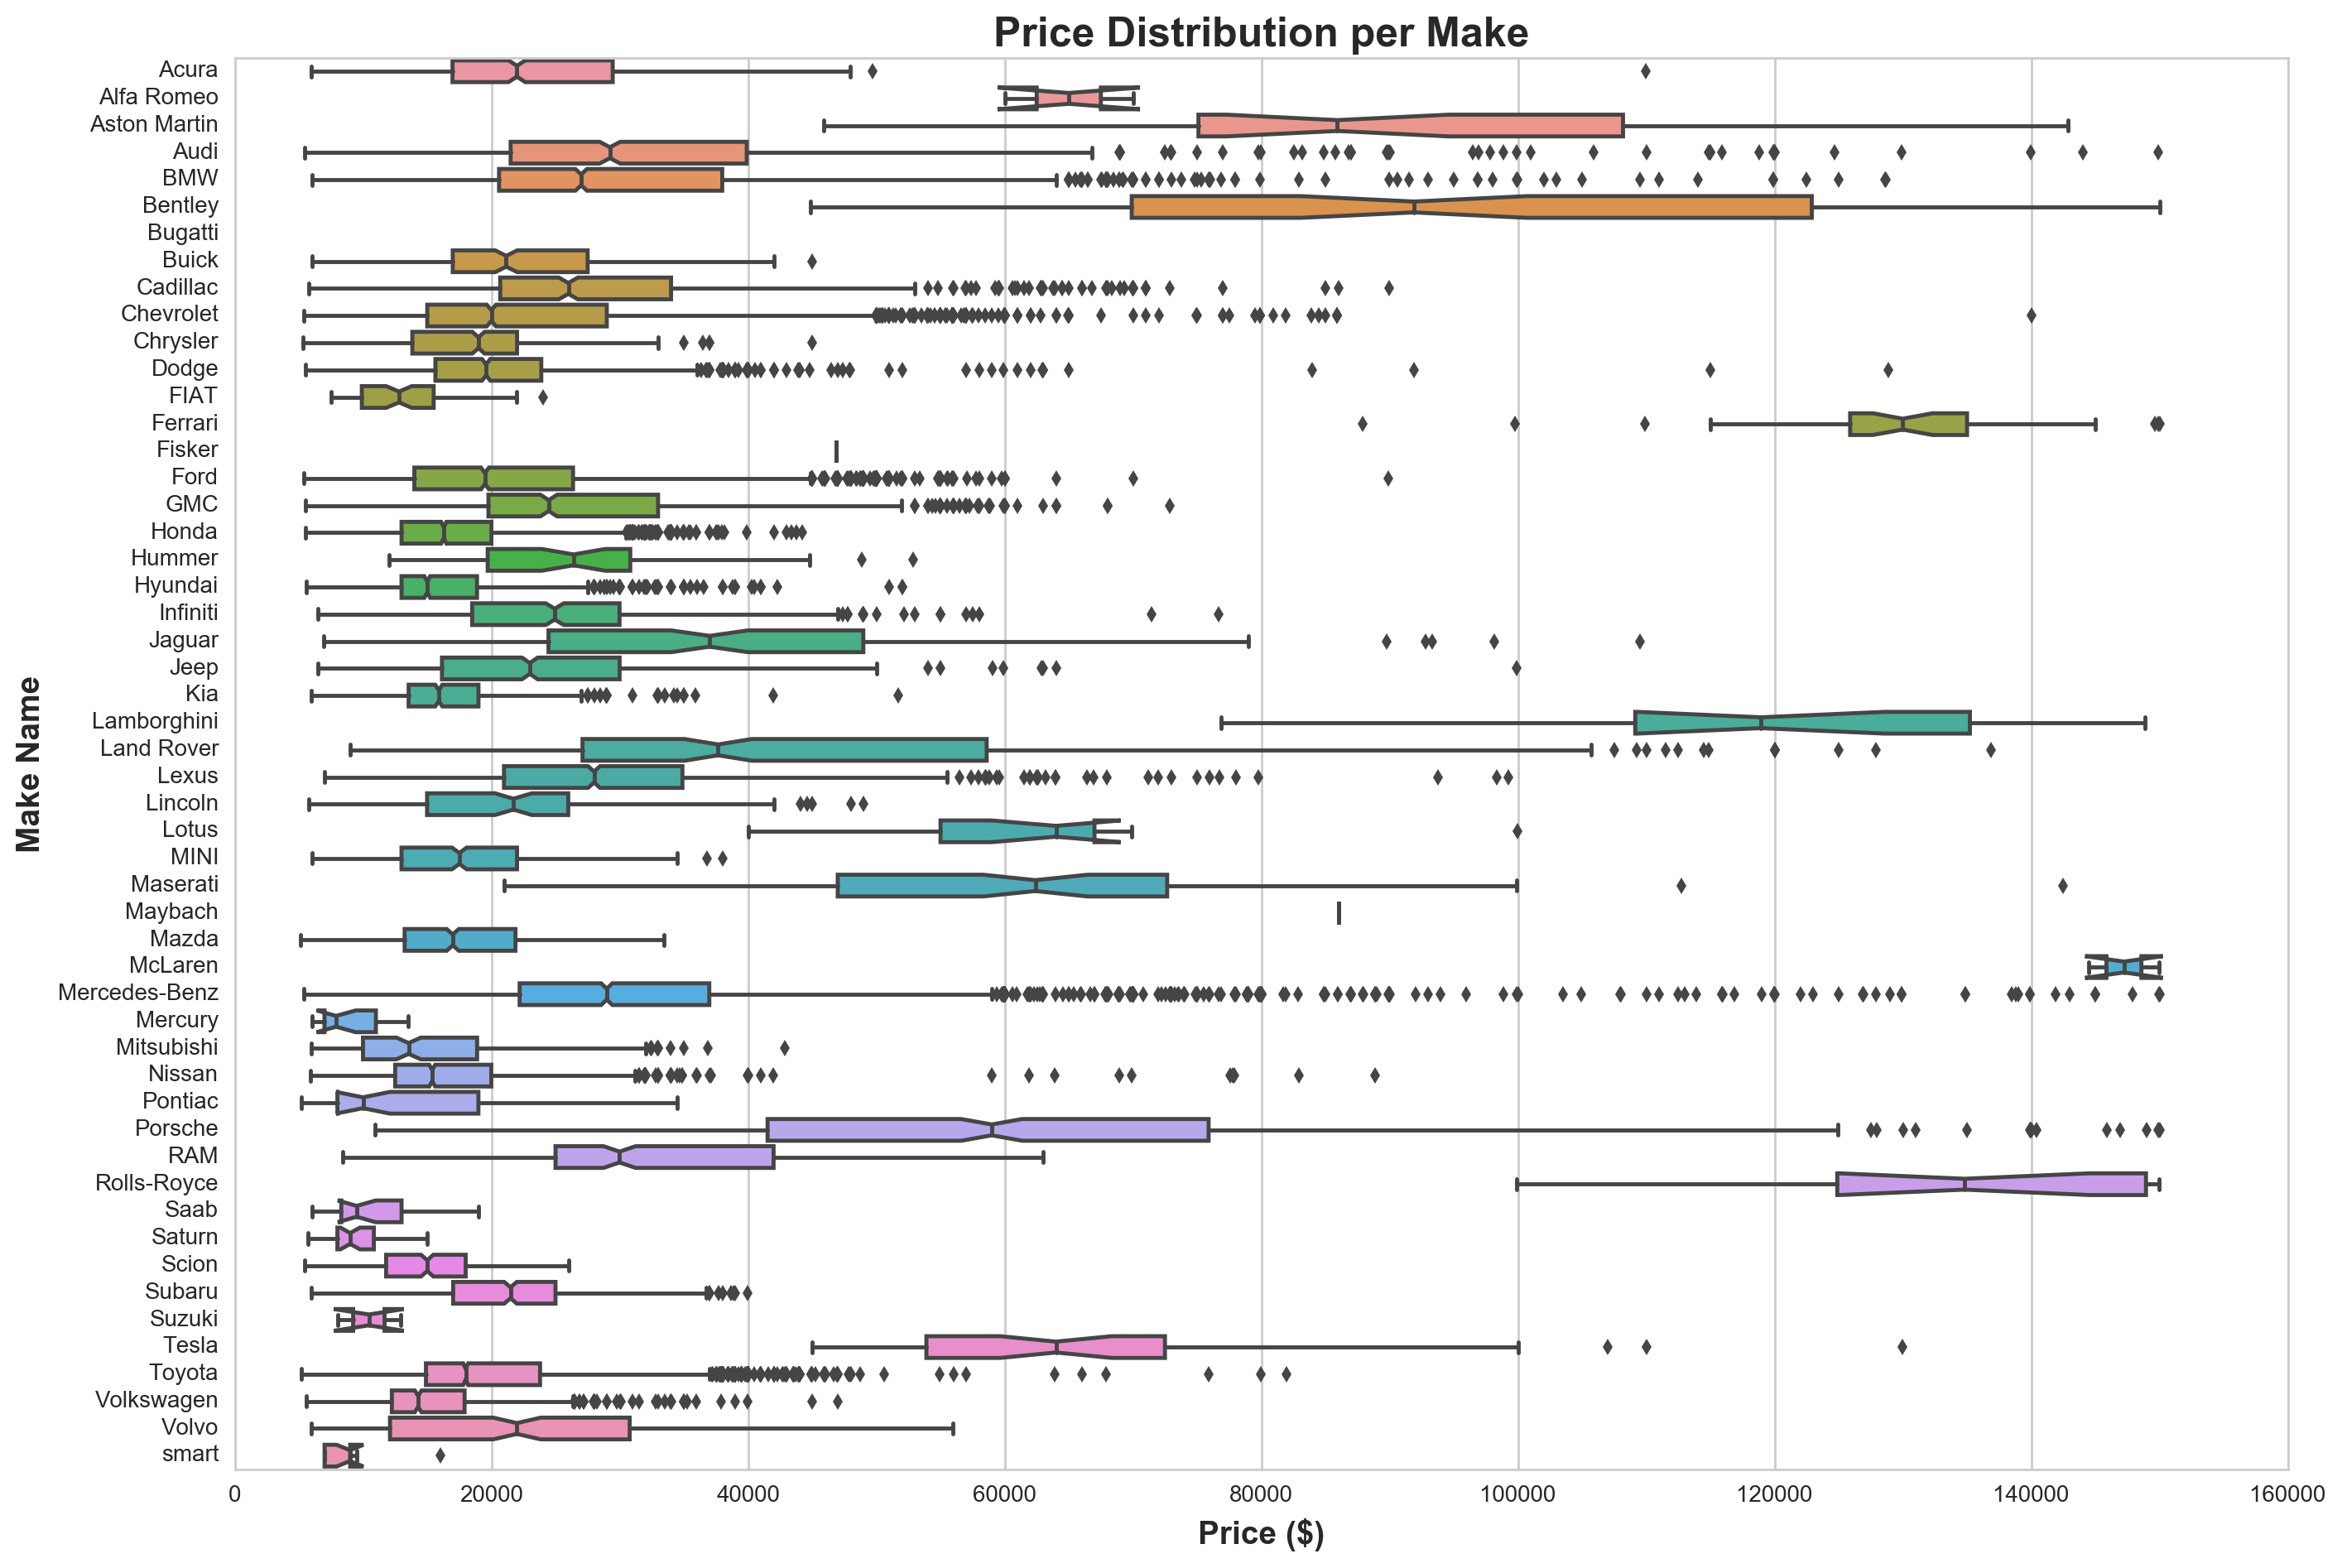

In [21]:
# look at price by make boxplot
# limit upper prices so it's more informative
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='price',y='makeName',data=cc_data[cc_data.price < 150000],
            order=sorted(cc_data.makeName.unique()),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=14,fontweight="bold")
plt.ylabel('Make Name',fontsize=14,fontweight="bold")
plt.title('Price Distribution per Make',fontsize=18,fontweight="bold")
plt.show()

The plot above shows that even with a specific make, there can be very large price variations. Not too surprising when you consider that many makes have a 'halo vehicle' that is sold at a high price and in very small numbers. I'm not going to plot the price breakdown for each model within a make, as that is simply too large a plot. 

However, I will still plot the price distribution by make per year, as it's important to show just how much the price changes over time. And while the prices tend to decrease with age, it's not always the case.

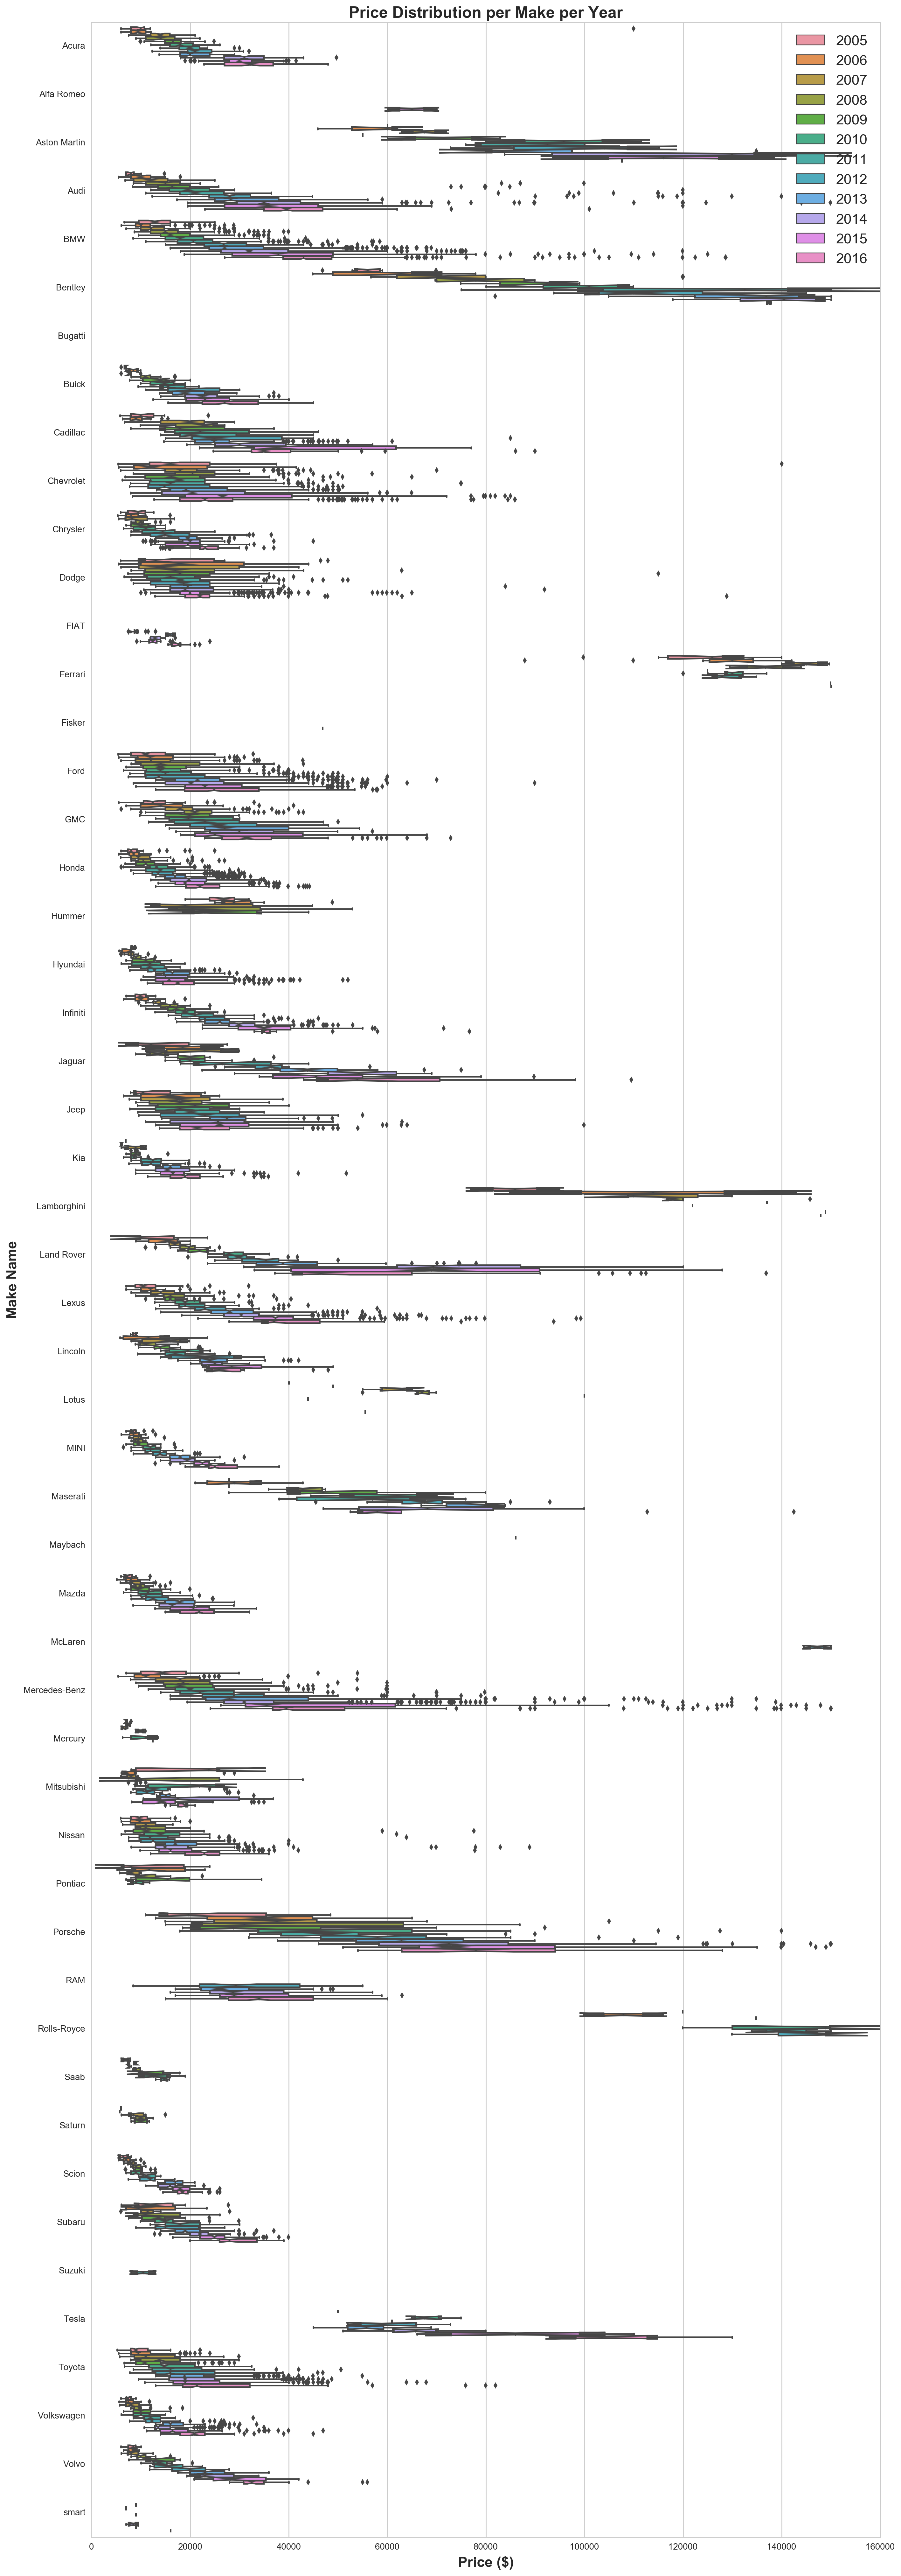

In [22]:
# look at price by make by year boxplot
# limit upper prices so it's more informative
# this has to be very large to get any details out

ordered_makes = sorted(cc_data.makeName.unique())

fig = plt.figure(figsize=(16,51))
ax = fig.gca()
sns.boxplot(x='price',y='makeName',data=cc_data[cc_data.price < 150000],
            order=ordered_makes,hue=(cc_data.modelYear),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=16,fontweight="bold")
plt.ylabel('Make Name',fontsize=16,fontweight="bold")
plt.title('Price Distribution per Make per Year',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.show()

# 6. Model Selection

## 6.1 Bayesian Linear Regression

In order to determine if a vehicle is a good value or not, I will use linear regression to predict the price of the vehicle and then compare it to the actual price. If they are similar, then it is 'reasonable,' otherwise the shopper may want to investigate why the vehicle is priced too high or low vs the prediction. 

This problem is ideally suited Bayesian methods, specifically to using a hierarchical model. As shown in the price by make and year distribution plot above, a traditional linear regression would likely have trouble producing reasonable predictions, even if the regression was done by make. Limiting it further by year, model and trim levels could negatively impact the performance due to potentially small sample sizes.

To get around this issue, I use a Bayes hierarchical model that predicts a price given the miles of the vehicle while taking into account prior knowledge about prices based on year, model and trim. This gives a distribution of estimated prices (posterior probabilities), against which the original asking price can be compared.

## 6.2 Recommendation Engine

For the recommendation engine, I will build a content-based model that is trained on the descriptive features available for each vehicle. With that, it will be possible to predict which vehicles are most similar to each other, and that information can be returned to the user.

To do this, I will create a sentence that describes each vehicle, composed of the following parts:
- year
- make
- model
- trim
- transmission
- drivetype
- engine
- exterior color
- interior color

From there, I will tokenize the sentence using the tf-idf vectorizer. This will return the proportion that each token appears in the overall collection of sentences, with the value weighted by it's frequency. N-gram values of 1 through 4 are used (one, two, three, and four-word phrases), as that ensures that the vehicles with the same 'year make model trim' will be ranked as highly similar to each other, with further sepration provided by the descriptors. Finally, the similarity ranking for each listing against all the other listings will be calculated using the cosine similarity function. Then the rankings can be sorted by similarity and used to do things such as finding a related vehicle with lower price.

# 7. Modeling

Create some new columns for the various modeling sections.

Make a column 'ymmt' containing year make model trim.

In [23]:
def ymmt_cc(df):

    # making all of these string, as some are numeric
    year = str(df.modelYear)
    make = str(df.makeName)
    model = str(df.modelName)
    # deal with case of no trim level
    if df.trimName != None:
        trim = str(df.trimName)
    else:
        trim = ''
    ymmt = ' '.join([year,make,model,trim])
    return ymmt
    
cc_data['ymmt'] = cc_data.apply(ymmt_cc,axis=1)
cc_data['ymmt'].head()

0                     2006 Ford F250 
1                   2006 Lotus Elise 
2    2006 Rolls-Royce Phantom VI Base
3            2006 Maserati GranSport 
4                   2006 Ford F350 XL
Name: ymmt, dtype: object

Add a column for engine displacement. This will make it easier to use engine-based info, as they will be all be formatted the same. Will set to *0* for electric vehicles.

In [24]:
# first do the non-electric cars
# can extract the displacement by looking for two digits separated by '.'
# that will diffrentiate from other descriptions such as '32V' 
cc_data['displacement'] = cc_data.engine.str.extract('(\d\.\d)',expand=False)
# set the type to float
cc_data.displacement.astype('float')

# Chevy Volt should be at 1.5
# this is called 'electric' in some listings, which is not quite correct
cc_data.displacement[cc_data.modelName == 'Volt'] = 1.5
cc_data.displacement[cc_data.modelName == 'Volt'].head()

# also need to set the displacement to 0 for electric vehicles
cc_data.displacement[(cc_data.fuelType == 'Electric') & (cc_data.modelName != 'Volt')] = 0.
print "Number of rows without engine displacement:", len(cc_data[['modelYear','makeName','modelName','engine']][cc_data.displacement.isnull() == True])

/Applications/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of rows without engine displacement: 1211


Create two additional columns for transmission:
- transAM: either 'automatic' or 'manual'
- transBin: 0 for automatic and 1 for manual

If there is no transmission info, will set to automatic as that's most common in US.

In [25]:
cc_data['transAM'] = cc_data.transmission.map(lambda x: 'manual' if ('man' in str(x).lower()) else 'automatic')
cc_data['transBin'] = cc_data.transmission.map(lambda x: 1 if ('man' in str(x).lower()) else 0)

Simplify the drivetrain options to:
- FWD: front wheel drive
- RWD: rear wheel drive
- AWD: all wheel drive

And store in a new column: drivetype

In [26]:
def set_drivetype(row):
    # initialize the output variable with '' in case there is not driveline info
    dt = ''
    # make sure there is some information to parse
    if row != None:
        dl = row.lower()
        # look for rear wheel drive
        if ('rear' in dl) or (dl == 'rwd'):
            dt = 'RWD'
        # look for front wheel drive
        elif (dl == 'fwd') or ('front' in dl):
            dt = 'FWD'
        # otherwise assume all wheel drive
        else:
            dt = 'AWD' 
        return dt
    
cc_data['drivetype'] = cc_data.drivetrain.map(set_drivetype)
print cc_data.drivetype.value_counts()
print cc_data.drivetype.unique()

FWD    20631
RWD    13762
AWD     9745
Name: drivetype, dtype: int64
['AWD' 'RWD' 'FWD' None]


Reset the index and save results to a with cPickle for use in the modeling steps. Output file is 175MB.

In [27]:
cc_data.reset_index(inplace=True,drop=True)

f= open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/cc_data_clean.p','w')
cPickle.dump(cc_data,f)
f.close()

## 7.1  Bayesian Linear Regression

The notebook containing the regression for the full dataset is in [Bayes Modeling](https://github.com/clrife/DSI-SF-2-clrife/blob/master/capstone/code/bayes_modeling.ipynb).

### Due to the size of the dataset and amount of time it takes to run the Bayes processing, I will limit the data here to a single make for use with model code shown below.

In [28]:
# in progress! See the linked notebook to see how the model has been evolving...

## 7.2 Recommendation Engine

Need some additional imports herem

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from PIL import Image
from matplotlib.pyplot import imshow

Reload the full dataset

In [30]:
f= open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/cc_data_clean.p','r')
cc_data = cPickle.load(f)
f.close()

In order to do content-based filtering, I need to create a 'sentence' that can be used in the tokenization process. I will do that by combing a number of columns together.

In [31]:
def create_sentence(df):
    y = str(df.ymmt)
    t = str(df.transAM)
    b = str(df.bodyStyle)
    d = str(df.doorCount) +'-door'
    dt = str(df.drivetype)
    dt2 = str(df.drivetrain)
    e = str(df.engine)
    extc = str(df.exteriorColor)
    intc = str(df.interiorColor)
    mcity = str(df.mpgCity)+'citympg'
    mhwy = str(df.mpgHwy)+'hwympg'
    p = str(df.price)
    
    s = " ".join([y,t,b,dt,e,extc,intc])
    return s
    
cc_data['sentence'] = cc_data.apply(create_sentence,axis=1)

In [32]:
print cc_data.sentence.loc[5]
print cc_data.sentence.loc[44332]

2006 BMW M6  automatic Coupe RWD 5.0L V10 40V MPFI DOHC Indianapolis Red Metallic Black
2016 Toyota Corolla Sedan automatic Sedan FWD Regular Unleaded I-4 1.8 L/110 Classic Silver Metallic Ash


Set up the tokenization using TfidfVectorizer. Use n-gram up to 4, so that it will catch the combinations of 'year make model trim', as that will be important in finding the vehicles with the most similarity.

In [33]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1,4),
                               min_df = 0)

tfidf_matrix = tf_vectorizer.fit_transform(cc_data['sentence'])

Next compute the cosine similarity for each listing against all other listings. This is very computationally intensive and takes significant time to complete.

In [34]:
d1 = datetime.now()
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
d2 = datetime.now()
time_diff = int((d2-d1).total_seconds())
print 'This took %s seconds' % (time_diff)

This took 465 seconds


Using the consine similarity results, create two additional columns:
1. similar_all: the 20 most similar results
2. similar_other_make: the 20 most similar results that are of a different make

In [35]:
all_similar = []
other_make_similar = []

for idx, row in cc_data.iterrows():
    if (idx % 5000) == 0:
        print "at index %s" % idx
        
    # limit to the 200 'most similar' listings
    similar_indices = cosine_similarities[idx].argsort()[:-200:-1]
    
    # Need to remove the parent item from the list,
    # otherwise it may show up due to the presence of
    # several indexes with the same value
    similar_indices = similar_indices[similar_indices != idx]

    
    # return the similarity and the index of the similar listing
    similar_items = [(cosine_similarities[idx][i], cc_data.index[i])
                     for i in similar_indices]
    
    # keep the list of all similar results
    # limit to 20 items
    all_similar.append(similar_items[0:20])
    
    # now lok for other makes
    sim_diff_make = []
    for position,(sim,item) in enumerate(similar_items):

        # get 20 similar listings that are a different make
        if cc_data.makeName.loc[idx] != cc_data.makeName.loc[item]:
            if len(sim_diff_make) <= 20:
                sim_diff_make.append(similar_items[position])
             
    # append the other similar makes
    other_make_similar.append(sim_diff_make)

    
cc_data['similar_all'] = all_similar
cc_data['similar_other_make'] = other_make_similar

# save the results
f= open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/cc_data_similarities.p','w')
cPickle.dump(cc_data,f)
f.close()

at index 0
at index 5000
at index 10000
at index 15000
at index 20000
at index 25000
at index 30000
at index 35000
at index 40000


Look at a couple to see if the results seem reasonable...

In [36]:
x = 50

# print cc_data.similar_all.loc[x][0:5]
# print cc_data.similar_other_make.loc[x][0:5]

print 'Parent listing: %s\n' % cc_data.sentence.loc[x]
print 'Similarity score and ymmt of top-five most similar listings:'
for i in cc_data.similar_all.loc[x][0:5]:
        print i[0],cc_data.sentence.loc[i[1]]

Parent listing: 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Gray Black

Similarity score and ymmt of top-five most similar listings:
0.913978512118 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Black Black
0.788923062186 2006 Porsche 911 Carrera manual Coupe RWD 3.8L H6 24V MPFI DOHC Red Sand Beige
0.739920789206 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Seal Gray Metallic Black
0.677455696819 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Lapis Blue Metallic Stone Grey
0.676074012457 2007 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Arctic Silver Metallic Black


In [37]:
x = 50

# print cc_data.similar_all.loc[x][0:5]
# print cc_data.similar_other_make.loc[x][0:5]

print 'Parent listing: %s\n' % cc_data.sentence.loc[x]
print 'Similarity score and ymmt of top-five most similar listings:'
for i in cc_data.similar_all.loc[x][0:5]:
        print i[0],cc_data.sentence.loc[i[1]]

Parent listing: 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Gray Black

Similarity score and ymmt of top-five most similar listings:
0.913978512118 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Black Black
0.788923062186 2006 Porsche 911 Carrera manual Coupe RWD 3.8L H6 24V MPFI DOHC Red Sand Beige
0.739920789206 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Seal Gray Metallic Black
0.677455696819 2006 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Lapis Blue Metallic Stone Grey
0.676074012457 2007 Porsche 911 Carrera S manual Coupe RWD 3.8L H6 24V MPFI DOHC Arctic Silver Metallic Black


#### Create functions to:

1. Return info about any listing
2. Return similar model at a lower price
3. Return similar model with lower miles
4. Return similar model with a higher price

If there is nothing to return, then will just add some text.

*1*. Return info about any listing

In [38]:
def get_info_to_display(ad_index):
    # this function will take an index from cc_data and return a list with details for printing
    
    # specifics from the listing
    # convert numbers to int
    year = str(cc_data.modelYear.loc[ad_index])
    model = str(cc_data.modelName.loc[ad_index])
    make = str(cc_data.makeName.loc[ad_index])
    trim = str(cc_data.trimName.loc[ad_index])
    price = int(cc_data.price.loc[ad_index])
    miles = int(cc_data.miles.loc[ad_index])
    ad_id = str(cc_data.ad_id.loc[ad_index])
    
    # not every listing has trim
    if trim != 'None':
        model_trim = model + ' ' + trim
    else:
        model_trim = model
        
    # get the file info for photo 0
    photo_file_parent = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/'
    photo_name = "_".join([make,model,year,ad_id,'0.jpg']).lower()
    photo_full = (photo_file_parent + photo_name)
    
    # put everything into a list
    display_info = [photo_full,year,make,model_trim,miles,price,ad_index]
    
    return display_info

*2*. Return similar model with a price 15% lower than the original listing

This will occasionally return none, especially when presented with the lowest priced vehicle of a type. 

In [39]:
def get_lower_price(ad_index):
    parent = ad_index
    parent_price = cc_data.price.loc[parent]
    # return a listing that has a vehicle similar to the original listing,
    # but with at least a 15% lower price
    # for the vehicles at the bottom of the price bracket, it probably not return anything
    
    # this method will take the parent and list of related vehicles for any of the
    # defined searches and return either the lower priced index, or None 
    def get_lower_price_index(parent,related_list):

        for item_score,item_index in related_list:
            # want to find listing with lower price
            d = cc_data.price.loc[parent] - cc_data.price.loc[item_index]        
            # look for price 15% lower than parent
            if (d > (parent_price * 0.15)):
                #if (item_index != get_lower_miles(parent)[6]):
                return item_index

    # look for something that is in the similar overall list
    similar_all_list = cc_data.similar_all.loc[parent]
    if len(similar_all_list) > 0:
        lpi = get_lower_price_index(parent,similar_all_list)
        # check to see if a value was returned or not
        if lpi:
            # If yes, return the details
            return get_info_to_display(lpi)
        
    # tIf no, then look for something that is similar and a different make
    sim_list = cc_data.similar_other_make.loc[parent]
    if len(sim_list) > 0:
        lpi = get_lower_price_index(parent,sim_list)
        # check to see if a value was returned or not
        if lpi:
            return get_info_to_display(lpi)
    
    # if none of the above, return None
    return None


*3*. Return similar model with at least 10% fewer miles than the parent listing. 

The price will likely be higher than the original listing.

In [40]:
def get_lower_miles(ad_index):
    # return a listing that has a vehicle similar to the original listing,
    # but with at least 10% fewer miles
    parent = ad_index
    parent_miles = cc_data.miles.loc[parent]
    
    # this method will take the parent and list of related vehicles for any of the
    # defined searches and return either the index, or None
    def get_lower_miles_index(parent,related_list):

        for item_score,item_index in related_list:
            # want to find listing with lower miles
            d = parent_miles - cc_data.miles.loc[item_index]        
            # look for 10% lower miles than parent
            if (d > (parent_miles * 0.1)):
                return item_index

    # look for something that is in the similar overall list
    similar_all_list = cc_data.similar_all.loc[parent]
    if len(similar_all_list) > 0:
        lpi = get_lower_miles_index(parent,similar_all_list)      
        # check to see if a value was returned or not
        if lpi:
            # If yes
            return get_info_to_display(lpi)
    
    # If no, then look for something that is similar and a different make
    sim_list = cc_data.similar_other_make.loc[parent]
    if len(sim_list) > 0:
        lpi = get_lower_miles_index(parent,sim_list)    
        # check to see if a value was returned or not
        if lpi:
            return get_info_to_display(lpi)
    
    
    # if none of the above, return None
    return None


*4*. Return similar model with a price around that is 1-30% higher than the parent.

In [41]:
def get_stretch_goal(ad_index):
    # this should return a listing that is slightly 'nicer' than
    # the parent listing, or at least more expensive
    parent = ad_index
    parent_price = cc_data.price.loc[parent]
    parent_miles = cc_data.miles.loc[parent]
    
    def get_higher_price(parent,related_list):

        for item_score,item_index in related_list:
            # want to find listing with higher price
            d = cc_data.price.loc[item_index] - cc_data.price.loc[parent]        
            
            # look for price 1-30% higher than parent
            if (d > parent_price * .01) & (d <= (parent_price * .30)):
                #if (item_index != get_lower_miles(parent)[6]) & (item_index != get_lower_miles(parent)[6]):
                return item_index

    # look for something similar 
    similar_all_list = cc_data.similar_all.loc[parent]
    if len(similar_all_list) > 0:
        lpi = get_higher_price(parent,similar_all_list)
        # check to see if a value was returned or not
        if lpi:
            # If yes
            return get_info_to_display(lpi)
        
    # If no, look for anything similar
    similar_other_list = cc_data.similar_other_make.loc[parent]
    if len(similar_other_list) > 0:
        lpi = get_higher_price(parent,similar_other_list)
        # check to see if a value was returned or not
        if lpi:
            return get_info_to_display(lpi)

    return None

In [42]:
x = 50
print '\t\tyear, \tmake, \tmodel, \tmiles, \tprice, \tindex'
print 'original',get_info_to_display(x)
print  'lower price',get_lower_price(x)
print 'lower miles',get_lower_miles(x)
print 'stretch',get_stretch_goal(x)

		year, 	make, 	model, 	miles, 	price, 	index
original ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/porsche_911_2006_674861484_0.jpg', '2006', 'Porsche', '911 Carrera S', 29801, 45950, 50]
lower price ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/porsche_911_2005_677602253_0.jpg', '2005', 'Porsche', '911 Carrera S', 115239, 26981, 25606]
lower miles ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/porsche_911_2006_680411096_0.jpg', '2006', 'Porsche', '911 Carrera', 20219, 39900, 94]
stretch ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/porsche_911_2006_674099133_0.jpg', '2006', 'Porsche', '911 Carrera S', 28605, 47885, 41]


Create a function that takes a listing index, and returns the lower price, lower miles, and 'stretch goal' listings. If the jpegs are available, show images and some listing information for each one.

In [49]:
def show_related(ad_index):
    # this will make sure the gridlines are off
    new_style = {'grid': False}
    matplotlib.rc('axes', **new_style)

    
    # first collect the info about the vehicle and related listings
    original = get_info_to_display(ad_index)
    lowerPrice = get_lower_price(ad_index)
    lowerMiles = get_lower_miles(ad_index)
    otherChoice = get_stretch_goal(ad_index)
    
    # image for cases where nothing is found
    no_car = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/no_image_thumb.jpg'
    
    # list of figures and titles
    fig_list = [original, lowerPrice, lowerMiles, otherChoice]
    title_list = ['Original','Lower Price','Lower Miles','Stretch Goal']
    
    # initialize a 2x2 plot
    fig, ax = plt.subplots(2,2,figsize=(8,8))
        
    for i in range(1,5):
        # adjust count to get 0-based for list indexing
        count = i - 1
        # check that there is an object to plot
        if fig_list[count] != None:
            # create the label to go under the photo
            # if the label has more than 30 characters, split into two lines
            ymm = " ".join((fig_list[count][1],fig_list[count][2],fig_list[count][3]))
            if len(ymm) > 30:
                 ymm = " ".join((fig_list[count][1],fig_list[count][2],'\n',fig_list[count][3]))
            # miles and price will be on separate lines
            mp = 'Miles: ' + str(fig_list[count][4]) + '\nPrice: ' + str(fig_list[count][5])
            label = "\n".join((ymm,mp))
            
            # make each plot, testing for image files and setting them all to the same size
            plt.subplot(2,2,i)
            try:
                pil_im = Image.open(fig_list[count][0],'r')
                pil_im = pil_im.resize((640, 480))
            except:
                pil_im = Image.open(no_car,'r')
                pil_im = pil_im.resize((640, 480))
                
            # set tiles and labels
            plt.title(title_list[count],fontsize=18)
            plt.xlabel(label,fontsize=14)
            
            # show the image without any tickmarks or other distractions
            imshow(np.asarray(pil_im))
            plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        else:
            # run this if no result was returned from any of the searches
            plt.subplot(2,2,i)
            pil_im = Image.open(no_car,'r')
            plt.title(title_list[count],fontsize=18)
            plt.xlabel('Nothing found!',fontsize=14)
            imshow(np.asarray(pil_im))
            plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', 
                right='off', left='off', labelleft='off')
            

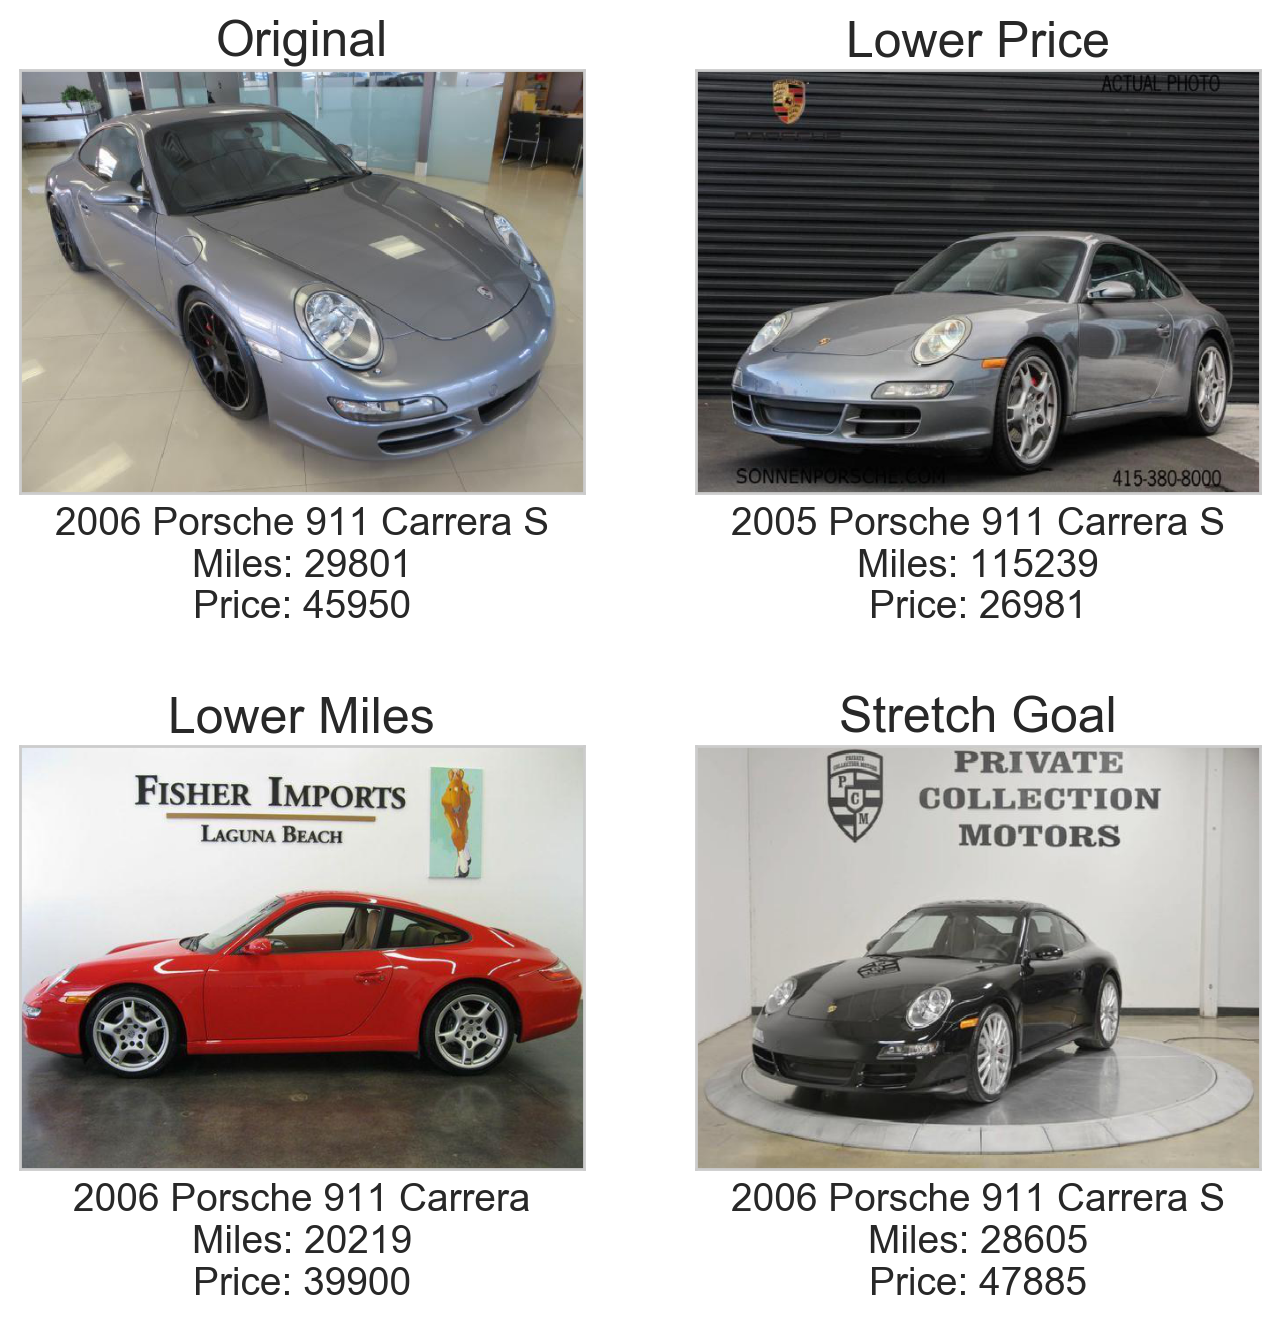

In [52]:
show_related(50)

# 8. Description of results

# 9. Conclusion